In [307]:
import os

# takes care of annoying TF-GPU warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [308]:
# very useful for managing wandb runs: https://stackoverflow.com/questions/71106179/log-two-model-runs-with-keras-wandb
import wandb
from wandb.keras import WandbCallback
os.environ["WANDB_SILENT"] = "true"

#### RNN: Formula Label Prediction 

In [309]:
import numpy as np 
import pandas as pd
from pathlib import Path 
import ast

import tensorflow as tf

from tensorflow.keras import layers 
from tensorflow.keras import utils

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import datetime

tfds.disable_progress_bar()

In [310]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])

#### Import Data and Preprocess Dataframe

In [311]:
def preprocess_data(corpus,
                    irrelevant_features=[]):
    # drop irrelevant columns
    corpus.drop(irrelevant_features, inplace=True, axis=1)
    def cell_str_to_list(cell_val):
        return ast.literal_eval(cell_val)

    # filter strings
    def process_cell(cell_str):
        stripped_f_str = cell_str[1:-1].replace("\\\\", "\\")
        f_list = stripped_f_str.split(",")
        f_list = [token.replace("'", "").replace(" ", "") for token in f_list]
        f_list = ["{" if token == "\\{" else token for token in f_list]
        f_list = ["}" if token == "\\}" else token for token in f_list]
        cell_str = " ".join(f_list)
        return cell_str

    corpus["tokens"] = corpus["tokens"].map(process_cell)
    corpus["labels"] = corpus["labels"].map(cell_str_to_list)
    corpus = corpus.loc[(corpus["tokens"].str.len() > 0) & (corpus["tokens"] != " ")]

In [312]:
data_p = Path("..") / "data" / "multi_class_data_TOKENIZED_V1.csv"
data = pd.read_csv(data_p)
preprocess_data(data)
data.head()


,mtype,tokens,type_tokens,labels,labels_str
0,FUNC,f,"['func_name', '__ANON_1']","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",['elementary-set-theory']
1,FUNC,j : \mathbb{N} \rightarrow [ 0 1 ],"['func_def', 'func_name', '__ANON_1', 'COLON',...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",['elementary-set-theory']
2,FUNC,b,"['func_name', '__ANON_1']","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",['elementary-set-theory']
3,SET,mathbb{Q,"['set_constant', 'SET_BASIC']","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",['elementary-set-theory']
4,FUNC,f,"['func_name', '__ANON_1']","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['functions', 'elementary-set-theory']"


In [313]:
num_classes = 40
labels_array = np.array(data["labels"].to_list())
data_as_ds = tf.data.Dataset.from_tensor_slices((data["tokens"], labels_array)) 
test_dataset = data_as_ds.take(3000)
train_dataset = data_as_ds.skip(3000)

##### Setup and Data Preparation

In [314]:
for example, label in train_dataset.take(1):
    print("text: ", example.numpy())
    print("labels: ", label.numpy())

text:  b'\\frac { j ( j - 1 ) } { 2 } + 1'
labels:  [1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


In [315]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

##### Text Encoding

In [316]:
def create_encoder(output_mode_str, n_grams):
    VOCAB_SIZE = 1000
    encoder = tf.keras.layers.TextVectorization(
        standardize=None,
        output_mode=output_mode_str,
        ngrams = n_grams,
        split="whitespace",
        max_tokens=VOCAB_SIZE)
    encoder.adapt(train_dataset.map(lambda tokens, label: tokens)) # removes the label column through transformation: text, label -> text
    return encoder

##### Representation 1: Use integer indices encoding

In [317]:
encoder_int = create_encoder("int", None)
vocab = np.array(encoder_int.get_vocabulary())
print("vocabulary size: ", len(vocab))
vocab[:200]

vocabulary size:  128


array(['', '[UNK]', 'f', '1', '2', 'x', '}', '{', '^', ')', '(', ':', '+',
       '0', '\\to', '-', '3', 'n', 'A', 'g', '=', 'a', '4', '5', 'B', 'b',
       '\\frac', '\\rightarrow', 'X', '6', '9', '7', '\\mathbb',
       '\\mathbb{R}', 'y', 'Y', '8', '\\mathbb{N}', 'h', 'c', 'p', 'R',
       'k', '/', '\\times', '\\colon', 'm', 'N', 'S', 'F', 'i', 't', 'd',
       'C', 'z', 's', 'e', 'q', '[', ']', 'r', '\\cdot', '\\cup', '!',
       '\\mathbb{Z}', 'mathbb{N', 'T', '\\dfrac', 'Z', '\\circ', '\\cap',
       'u', 'P', 'si', 'G', 'D', 'M', 'I', 'varnothin', 'co', 'E', 'Q',
       'U', '*', 'mathbb{R', 'j', 'H', 'V', 'v', 'W', 'l', 'w',
       '\\mathbb{Q}', 'mathbb{Z', '\\binom', 'J', 'ta', '\\mathbb{C}',
       'o', 'arcta', 'arcsi', 'L', 'K', 'mathbb{Q', 'lo', '\\varnothing)',
       'Token(sets__SET_EMPTY', 'ex', '\\varnothing', '\\sin', '\\exp',
       'O', 'arcco', '\\tfrac', 'mathbb{A', 'cos', '\\arcsin', 'tan',
       'sin', '\\tanh', '\\log', '\\div', '\\cos', 'se', 'mathbb{C',
 

In [318]:
encoded_example = encoder_int(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b'\\frac { j ( j - 1 ) } { 2 } + 1', shape=(), dtype=string)
[26  7 85 10 85 15  3  9  6  7  4  6 12  3]


In [319]:
print("Original: ", example.numpy())
print("After reverse lookup: ", " ".join(vocab[encoded_example]))

Original:  b'\\frac { j ( j - 1 ) } { 2 } + 1'
After reverse lookup:  \frac { j ( j - 1 ) } { 2 } + 1


##### Representation 2: Binary Count Vectorizer

In [221]:
encoder_multi_hot = create_encoder("multi_hot", None)
vocab = np.array(encoder_multi_hot.get_vocabulary())
vocab[:200]

array(['[UNK]', "['f',", "'x',", "'^',", "['f']", "'{',", "'(',", "'1',",
       "':',", "'2',", "'+',", "')',", "'\\\\to',", "'-',", "'0',",
       "'}',", "'=',", "',',", "'}']", "'3',", '1', "['1',", "'n',",
       "')']", "'1']", "'\\\\rightarrow',", "'4',", "'A',", "'a',",
       "['2',", "'B']", "'b',", "'2']", "'5',", '0', "['g']", "'\\\\}']",
       "'0']", "['g',", "'X',", "['\\\\{',", "'\\\\mathbb',",
       "['\\\\frac',", '2', "'6',", "'7',", "'Y']", "'9',", "'/',",
       "'y',", "['a',", "'\\\\frac',", '3', "'8',", "['(',",
       "'\\\\colon',", "'\\\\times',", "'3']", "'\\\\mathbb{N}',",
       "'\\\\mathbb{R}',", "'x']", "'\\\\mathbb{R}']", "['3',", "['n',",
       "'c',", "'A']", "'n']", "'5']", '5', "'4']", "['h']", "['4',",
       "['-',", "'k',", "'\\\\mathbb{N}']", "'B',", "['x',", '4', "['A',",
       "['F']", "'t',", "'R']", "'m',", "'7']", "'6']", "['h',", "'p',",
       "'b']", "'X']", "'R',", "['p',", '9', "'N']", "'N',", "'z',",
       "'9']", '6', "['5',", 

In [222]:
encoded_example = encoder_multi_hot(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b"['\\\\frac', '{', 'j', '(', 'j', '-', '1', ')', '}', '{', '2', '}', '+', '1']", shape=(), dtype=string)
[0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0

##### Representation 3: Frequency Count Vectorizer

In [223]:
encoder_count = create_encoder("count", None)
vocab = np.array(encoder_count.get_vocabulary())
vocab[:200]

array(['[UNK]', "['f',", "'x',", "'^',", "['f']", "'{',", "'(',", "'1',",
       "':',", "'2',", "'+',", "')',", "'\\\\to',", "'-',", "'0',",
       "'}',", "'=',", "',',", "'}']", "'3',", '1', "['1',", "'n',",
       "')']", "'1']", "'\\\\rightarrow',", "'4',", "'A',", "'a',",
       "['2',", "'B']", "'b',", "'2']", "'5',", '0', "['g']", "'\\\\}']",
       "'0']", "['g',", "'X',", "['\\\\{',", "'\\\\mathbb',",
       "['\\\\frac',", '2', "'6',", "'7',", "'Y']", "'9',", "'/',",
       "'y',", "['a',", "'\\\\frac',", '3', "'8',", "['(',",
       "'\\\\colon',", "'\\\\times',", "'3']", "'\\\\mathbb{N}',",
       "'\\\\mathbb{R}',", "'x']", "'\\\\mathbb{R}']", "['3',", "['n',",
       "'c',", "'A']", "'n']", "'5']", '5', "'4']", "['h']", "['4',",
       "['-',", "'k',", "'\\\\mathbb{N}']", "'B',", "['x',", '4', "['A',",
       "['F']", "'t',", "'R']", "'m',", "'7']", "'6']", "['h',", "'p',",
       "'b']", "'X']", "'R',", "['p',", '9', "'N']", "'N',", "'z',",
       "'9']", '6', "['5',", 

In [224]:
encoded_example = encoder_count(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b"['\\\\frac', '{', 'j', '(', 'j', '-', '1', ')', '}', '{', '2', '}', '+', '1']", shape=(), dtype=string)
[0. 0. 0. 0. 0. 2. 1. 1. 0. 1. 1. 1. 0. 1. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0

##### Representation 4: Bigrams Frequency Count Vectorizer

In [225]:
encoder_bigrams = create_encoder("count", (2))
vocab = np.array(encoder_bigrams.get_vocabulary())
vocab[:200]

array(['[UNK]', "['f',", "'x',", "'^',", "['f']", "'{',", "'(',", "'1',",
       "':',", "'2',", "'+',", "')',", "'\\\\to',", "['f', ':',", "'-',",
       "'0',", "'}',", "'(', 'x',", "'=',", "')', '=',", "',',",
       "['f', '(',", "'}']", "'3',", '1', "['1',", "'x', ')',",
       "'}', '{',", "'n',", "')']", "'1']", "'\\\\rightarrow',",
       "'^', '2',", "'4',", "'A',", "'a',", "['2',", "'B']", "'b',",
       "'x', '^',", "'^', '{',", "'2']", "'5',", '0', "['g']",
       "':', 'A',", "'\\\\}']", "'0']", "['g',", "'X',", "['\\\\{',",
       "'\\\\mathbb',", "['\\\\frac', '{',", "['\\\\frac',", '2',
       "'{', '1',", "'A', '\\\\to',", "':', 'X',", "'6',", "'7',", "'Y']",
       "'9',", "'/',", "'2', '+',", "'-', '1',", "'y',", "'x', '+',",
       "['a',", "'{', '2',", "'\\\\to', 'B']", "'^', '2']",
       "'\\\\frac', '{',", "'\\\\frac',", '3', "'8',", "'1', '}',",
       "'+', '1',", "'X', '\\\\to',", "['(',", "'\\\\colon',",
       "'\\\\times',", "'0', '0',", "'{', 'x',", "',',

In [226]:
encoded_example = encoder_bigrams(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b"['\\\\frac', '{', 'j', '(', 'j', '-', '1', ')', '}', '{', '2', '}', '+', '1']", shape=(), dtype=string)
[4. 0. 0. 0. 0. 2. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0

##### Representation 5: Tf-Idf Vectorizer

In [227]:
encoder_tf_idf = create_encoder("tf_idf", None)
vocab = np.array(encoder_tf_idf.get_vocabulary())
vocab[:200]

array(['[UNK]', "['f',", "'x',", "'^',", "['f']", "'{',", "'(',", "'1',",
       "':',", "'2',", "'+',", "')',", "'\\\\to',", "'-',", "'0',",
       "'}',", "'=',", "',',", "'}']", "'3',", '1', "['1',", "'n',",
       "')']", "'1']", "'\\\\rightarrow',", "'4',", "'A',", "'a',",
       "['2',", "'B']", "'b',", "'2']", "'5',", '0', "['g']", "'\\\\}']",
       "'0']", "['g',", "'X',", "['\\\\{',", "'\\\\mathbb',",
       "['\\\\frac',", '2', "'6',", "'7',", "'Y']", "'9',", "'/',",
       "'y',", "['a',", "'\\\\frac',", '3', "'8',", "['(',",
       "'\\\\colon',", "'\\\\times',", "'3']", "'\\\\mathbb{N}',",
       "'\\\\mathbb{R}',", "'x']", "'\\\\mathbb{R}']", "['3',", "['n',",
       "'c',", "'A']", "'n']", "'5']", '5', "'4']", "['h']", "['4',",
       "['-',", "'k',", "'\\\\mathbb{N}']", "'B',", "['x',", '4', "['A',",
       "['F']", "'t',", "'R']", "'m',", "'7']", "'6']", "['h',", "'p',",
       "'b']", "'X']", "'R',", "['p',", '9', "'N']", "'N',", "'z',",
       "'9']", '6', "['5',", 

In [228]:
encoded_example = encoder_tf_idf(example).numpy()
print(example)
print(encoded_example)

tf.Tensor(b"['\\\\frac', '{', 'j', '(', 'j', '-', '1', ')', '}', '{', '2', '}', '+', '1']", shape=(), dtype=string)
[ 0.         0.         0.         0.         0.         5.512187
  2.3759446  2.5485842  0.         2.5839868  2.6291504  2.6068108
  0.         2.8355234  0.         5.9615707  0.         0.
  0.         0.         0.         0.         0.         0.
  3.18321    0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  3.7476091  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.     

##### Model (Bidirectional LSTM with one layer)

 **Define and compile model**

In [321]:
def create_model(vec_encoder):
    model = tf.keras.Sequential([
        vec_encoder,
        tf.keras.layers.Embedding(
            input_dim=len(vec_encoder.get_vocabulary()),
            output_dim=64,
            # user masking to handle the variable sequence lengths
            mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(40)
    ])
    return model

 **Train the model**

##### Experiment 1: Use integer indices for encoding tokens

In [230]:
### TENSORBOARD USAGE
#log_dir = "4_nlp_rnns/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [322]:
model = create_model(encoder_int)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[ 1.6582372e-03  6.2778126e-04 -2.7862552e-03 -5.8722273e-03
  1.2377028e-02 -2.1434089e-03  1.2793786e-02  4.3071364e-03
  2.2178516e-03  1.3701826e-02  3.9551067e-03 -1.8063015e-03
 -5.2499082e-03 -3.4854887e-03  8.1927581e-03  1.3902756e-02
  7.0966617e-03 -2.0434964e-03 -7.1388241e-03 -3.4556554e-03
 -5.3802761e-03 -5.2787655e-06 -1.2853208e-02 -2.4950656e-03
  4.1533648e-03 -2.0475134e-03  1.4426299e-02 -1.8913840e-03
  5.7074390e-03 -7.2349492e-04  3.6168073e-03 -4.6964288e-03
 -7.8344960e-03 -3.5198703e-03 -1.3287126e-03  2.2764369e-03
  1.9176981e-03  3.4419880e-03 -3.7052738e-03 -2.9125421e-03]


In [323]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=["accuracy"])

In [324]:
configs_dict = {
    "learning_rate": 1e-3,
    "optimizer": "adam",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "int",
    "sample_id": "2",
    "num_labels": "40"
}

run = wandb.init(project="multi_label_everything_v1", reinit=True, config=configs_dict)

history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
337/338 [============================>.] - ETA: 0s - loss: 0.2520 - accuracy: 0.4173

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_132746-1ojy3kxw\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_132746-1ojy3kxw\files\model-best\assets


338/338 [==============================] - 49s 123ms/step - loss: 0.2518 - accuracy: 0.4176 - val_loss: 0.1478 - val_accuracy: 0.6172
Epoch 2/15
338/338 [==============================] - ETA: 0s - loss: 0.1394 - accuracy: 0.5816

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_132746-1ojy3kxw\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_132746-1ojy3kxw\files\model-best\assets


338/338 [==============================] - 43s 127ms/step - loss: 0.1394 - accuracy: 0.5816 - val_loss: 0.1222 - val_accuracy: 0.8057
Epoch 3/15
338/338 [==============================] - 14s 41ms/step - loss: 0.1292 - accuracy: 0.6098 - val_loss: 0.1248 - val_accuracy: 0.7896
Epoch 4/15
337/338 [============================>.] - ETA: 0s - loss: 0.1268 - accuracy: 0.6219

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_132746-1ojy3kxw\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_132746-1ojy3kxw\files\model-best\assets


338/338 [==============================] - 45s 133ms/step - loss: 0.1268 - accuracy: 0.6216 - val_loss: 0.1208 - val_accuracy: 0.7969
Epoch 5/15
338/338 [==============================] - ETA: 0s - loss: 0.1257 - accuracy: 0.6290

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_132746-1ojy3kxw\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_132746-1ojy3kxw\files\model-best\assets


338/338 [==============================] - 44s 130ms/step - loss: 0.1257 - accuracy: 0.6290 - val_loss: 0.1183 - val_accuracy: 0.8083
Epoch 6/15
338/338 [==============================] - 13s 39ms/step - loss: 0.1250 - accuracy: 0.6320 - val_loss: 0.1219 - val_accuracy: 0.7979
Epoch 7/15
338/338 [==============================] - 14s 40ms/step - loss: 0.1248 - accuracy: 0.6317 - val_loss: 0.1212 - val_accuracy: 0.7974
Epoch 8/15
338/338 [==============================] - 13s 39ms/step - loss: 0.1240 - accuracy: 0.6366 - val_loss: 0.1241 - val_accuracy: 0.7906
Epoch 9/15
338/338 [==============================] - 13s 40ms/step - loss: 0.1239 - accuracy: 0.6372 - val_loss: 0.1186 - val_accuracy: 0.8000
Epoch 10/15
338/338 [==============================] - 13s 40ms/step - loss: 0.1232 - accuracy: 0.6374 - val_loss: 0.1216 - val_accuracy: 0.7901
Epoch 11/15
337/338 [============================>.] - ETA: 0s - loss: 0.1230 - accuracy: 0.6385

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_132746-1ojy3kxw\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_132746-1ojy3kxw\files\model-best\assets


338/338 [==============================] - 40s 119ms/step - loss: 0.1230 - accuracy: 0.6382 - val_loss: 0.1178 - val_accuracy: 0.8083
Epoch 12/15
338/338 [==============================] - 13s 39ms/step - loss: 0.1226 - accuracy: 0.6381 - val_loss: 0.1209 - val_accuracy: 0.7953
Epoch 13/15
338/338 [==============================] - 13s 39ms/step - loss: 0.1223 - accuracy: 0.6395 - val_loss: 0.1186 - val_accuracy: 0.8094
Epoch 14/15
338/338 [==============================] - 13s 40ms/step - loss: 0.1219 - accuracy: 0.6400 - val_loss: 0.1216 - val_accuracy: 0.8036
Epoch 15/15
338/338 [==============================] - 13s 39ms/step - loss: 0.1216 - accuracy: 0.6382 - val_loss: 0.1195 - val_accuracy: 0.8010


In [325]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

47/47 [==============================] - 0s 6ms/step - loss: 0.1202 - accuracy: 0.8060
Test Loss: 0.12019454687833786
Test Accuracy: 0.8059999942779541


(0.0, 0.2585169721394777)

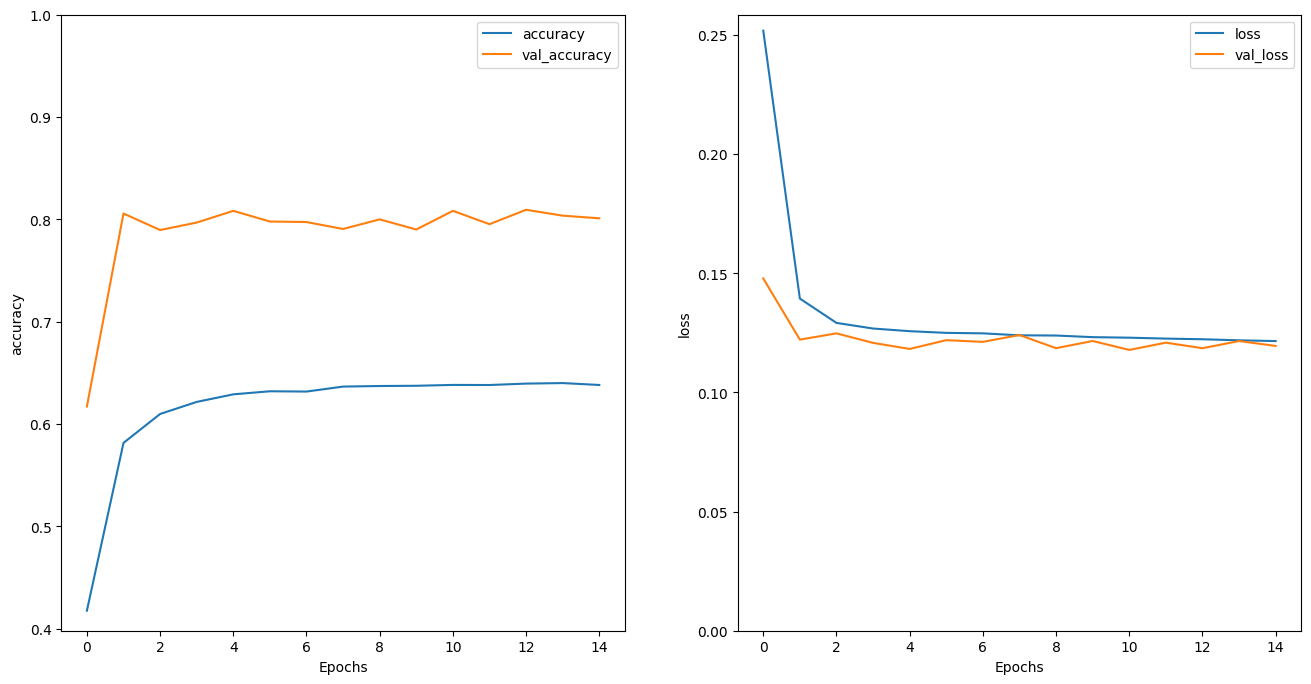

In [326]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [327]:
labels_list = ["elementary-set-theory", "elementary-number-theory", "algebra-precalculus", "functions", "trigonometry", \
               "number-theory", "calculus", "real-analysis", "discrete-mathematics", "combinatorics", "proof-verification", \
               "prime-numbers", "cardinals", "proof-writing", "contest-math", "divisibility", "solution-verification", "modular-arithmetic", \
               "inequality", "notation", "geometry", "general-topology", "sequences-and-series", "polynomials", "logic", "euclidean-geometry", \
               "abstract-algebra", "arithmetic", "relations", "definition", "analytic-geometry", "decimal-expansion", "recreational-mathematics", \
               "proof-explanation", "functional-equations", "elementary-functions", "limits", "induction", "complex-numbers", "terminology"]

In [335]:
def predictions_to_labels(prediction_arr):
    def sort_index(lst, rev=True):
        index = range(len(lst))
        s = sorted(index, reverse=rev, key=lambda i: lst[i]) 
        return s
    prediction_ls = list(prediction_arr)
    top_3_indices = sort_index(prediction_ls)[:3]
    return [(labels_list[elem],prediction_ls[elem]) for elem in top_3_indices]

In [336]:
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions_to_labels(predictions[0]))

1/1 [==============================] - 0s 25ms/step
[('algebra-precalculus', 0.25392962), ('trigonometry', -0.8927269), ('functions', -1.0184162)]


In [337]:
sample_text = ("\\{ \\varnothing \\}")
predictions = model.predict(np.array([sample_text]))
print(predictions_to_labels(predictions[0]))

1/1 [==============================] - 0s 22ms/step
[('elementary-set-theory', 0.6662782), ('elementary-number-theory', -1.1404643), ('functions', -1.3648176)]


In [338]:
sample_text = ("f ( x ) = x * x")
predictions = model.predict(np.array([sample_text]))
print(predictions_to_labels(predictions[0]))

1/1 [==============================] - 0s 23ms/step
[('algebra-precalculus', 0.30892295), ('elementary-number-theory', -1.6004566), ('functions', -1.6851017)]


In [339]:
sample_text = ("f ( x ) = \\sin ( x )")
predictions = model.predict(np.array([sample_text]))
print(predictions_to_labels(predictions[0]))

1/1 [==============================] - 0s 24ms/step
[('algebra-precalculus', 0.018969364), ('trigonometry', -0.29382795), ('functions', -1.3319225)]


In [340]:
sample_text = ("f : N \\to X \\times X")
predictions = model.predict(np.array([sample_text]))
print(predictions_to_labels(predictions[0]))

1/1 [==============================] - 0s 24ms/step
[('elementary-set-theory', 2.517617), ('functions', -1.6924803), ('cardinals', -1.8402693)]


In [342]:
sample_text = ("\\frac { a + b } { c - d } ")
predictions = model.predict(np.array([sample_text]))
print(predictions_to_labels(predictions[0]))

1/1 [==============================] - 0s 25ms/step
[('elementary-number-theory', -0.09290438), ('algebra-precalculus', -0.29742151), ('trigonometry', -1.870779)]


In [343]:
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_26 (Text  (None, None)             0         
 Vectorization)                                                  
                                                                 
 embedding_9 (Embedding)     (None, None, 64)          8192      
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 40)                2600      
                                                                 
Total params: 85,096
Trainable params: 85,096
Non-trai

In [ ]:
weights = model.get_layer("embedding_9").get_weights()[0]
vocab = encoder_int.get_vocabulary()

In [ ]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()


##### Experiment 2: Use binary count vectorizer for encoding

In [243]:
model = create_model(encoder_multi_hot)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[-9.8992800e-03 -1.2591374e-03  5.9022238e-03  1.0879994e-02
 -7.0673898e-03 -1.0374987e-03 -7.1757259e-03 -9.3838107e-03
 -1.3152701e-02  1.2541844e-03  8.0972658e-03 -3.1892029e-03
  2.1310928e-04  5.9648030e-03 -5.0134254e-03  2.7442155e-03
  5.4294986e-05 -3.7586770e-03  1.2586103e-02  1.0172410e-02
 -6.3387427e-04  9.3825758e-03 -1.3013278e-02  1.2944211e-02
 -1.3997213e-02  5.0704979e-04 -2.4676381e-04 -1.5183514e-03
 -1.1595828e-02 -1.6502874e-02 -2.0208942e-02  5.9619178e-03
 -1.1128376e-02 -6.7477799e-03 -1.5183290e-02 -8.0857156e-03
 -5.6071198e-03  1.3085045e-02 -1.9954909e-03 -7.6873098e-03]


In [244]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=["accuracy"])

In [245]:
run = wandb.init(project="multi_label_everything_v1", reinit=True)
wandb.config = {
    "learning_rate": 1e-3,
    "optimizer": "adam",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "multi_hot",
    "sample_id": "2"
}

history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
338/338 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 0.3679

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_225720-282adjh1\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_225720-282adjh1\files\model-best\assets


338/338 [==============================] - 202s 576ms/step - loss: 0.2008 - accuracy: 0.3679 - val_loss: 0.1521 - val_accuracy: 0.0000e+00
Epoch 2/15
338/338 [==============================] - 168s 498ms/step - loss: 0.1430 - accuracy: 0.4290 - val_loss: 0.1528 - val_accuracy: 0.0000e+00
Epoch 3/15
338/338 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.4703

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_225720-282adjh1\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_225720-282adjh1\files\model-best\assets


338/338 [==============================] - 193s 570ms/step - loss: 0.1413 - accuracy: 0.4703 - val_loss: 0.1476 - val_accuracy: 0.2984
Epoch 4/15
338/338 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.4717

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_225720-282adjh1\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_225720-282adjh1\files\model-best\assets


338/338 [==============================] - 229s 677ms/step - loss: 0.1406 - accuracy: 0.4717 - val_loss: 0.1433 - val_accuracy: 0.2984
Epoch 5/15
338/338 [==============================] - ETA: 0s - loss: 0.1402 - accuracy: 0.4819

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_225720-282adjh1\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_225720-282adjh1\files\model-best\assets


338/338 [==============================] - 230s 681ms/step - loss: 0.1402 - accuracy: 0.4819 - val_loss: 0.1425 - val_accuracy: 0.2984
Epoch 6/15
338/338 [==============================] - 194s 574ms/step - loss: 0.1400 - accuracy: 0.4800 - val_loss: 0.1446 - val_accuracy: 0.2984
Epoch 7/15
338/338 [==============================] - 185s 547ms/step - loss: 0.1401 - accuracy: 0.4777 - val_loss: 0.1428 - val_accuracy: 0.2984
Epoch 8/15
338/338 [==============================] - 189s 558ms/step - loss: 0.1399 - accuracy: 0.4781 - val_loss: 0.1426 - val_accuracy: 0.2984
Epoch 9/15
338/338 [==============================] - 188s 556ms/step - loss: 0.1402 - accuracy: 0.4740 - val_loss: 0.1437 - val_accuracy: 0.2984
Epoch 10/15
338/338 [==============================] - 187s 554ms/step - loss: 0.1402 - accuracy: 0.4779 - val_loss: 0.1444 - val_accuracy: 0.2984
Epoch 11/15
338/338 [==============================] - 187s 553ms/step - loss: 0.1401 - accuracy: 0.4762 - val_loss: 0.1440 - val_accu

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_225720-282adjh1\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_225720-282adjh1\files\model-best\assets


338/338 [==============================] - 205s 606ms/step - loss: 0.1401 - accuracy: 0.4765 - val_loss: 0.1409 - val_accuracy: 0.2984
Epoch 13/15
338/338 [==============================] - 169s 499ms/step - loss: 0.1403 - accuracy: 0.4745 - val_loss: 0.1415 - val_accuracy: 0.2984
Epoch 14/15
338/338 [==============================] - 169s 499ms/step - loss: 0.1402 - accuracy: 0.4770 - val_loss: 0.1419 - val_accuracy: 0.2984
Epoch 15/15
338/338 [==============================] - 170s 502ms/step - loss: 0.1403 - accuracy: 0.4741 - val_loss: 0.1429 - val_accuracy: 0.2984


In [246]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

47/47 [==============================] - 5s 102ms/step - loss: 0.1445 - accuracy: 0.2970
Test Loss: 0.14449208974838257
Test Accuracy: 0.296999990940094


(0.0, 0.20379702523350715)

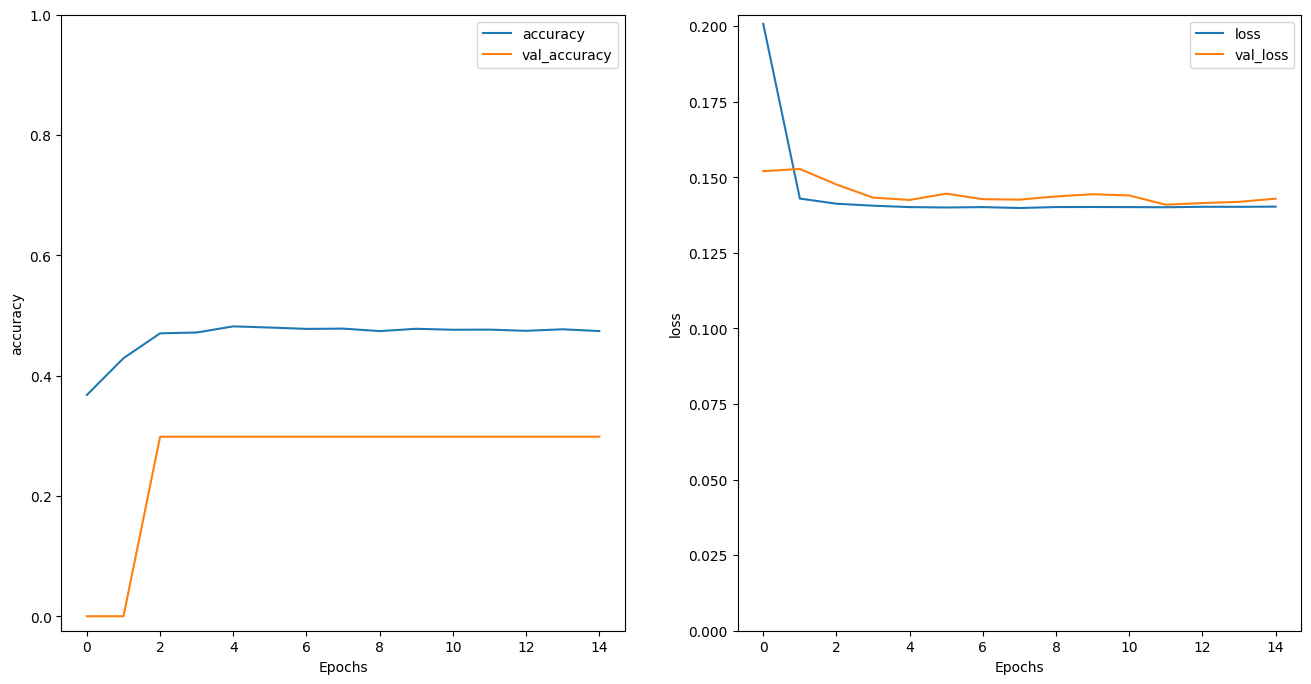

In [247]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [248]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-1.3531058   0.30209833 -1.4726005  -3.2256439  -2.5685356  -2.241483
 -3.8509758  -3.6979842  -3.0975428  -3.1920385  -3.978696   -2.633955
 -5.1075997  -4.121196   -3.4524913  -3.1710644  -4.378172   -3.4443107
 -3.8705769  -4.3274074  -3.6615484  -4.2722254  -3.874273   -4.6846633
 -4.7134967  -3.749981   -4.458452   -3.7068353  -4.58309    -4.960247
 -4.756445   -4.052264   -3.4968317  -4.518767   -5.8304505  -6.127541
 -5.4694405  -4.2557626  -4.6092916  -5.7345376 ]


##### Experiment 3:

In [249]:
model = create_model(encoder_count)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[ 1.5049626e-03 -9.7161224e-03  1.1495914e-03  1.5763764e-04
  6.0587274e-03 -1.2012719e-03 -8.6602634e-03  5.4164054e-03
  9.2748329e-03 -4.4858875e-03 -8.8869699e-04 -1.9208589e-03
  1.2710802e-02  3.0258147e-03 -1.8271089e-03  3.8838687e-03
  4.0030451e-03  3.0023104e-05 -4.1399677e-03 -4.6849943e-04
 -1.8059844e-03  5.8975965e-03  1.1954630e-03 -3.7405971e-03
  8.8598207e-04 -3.7824691e-03 -7.1163839e-03  6.0644913e-03
  8.7079918e-03 -1.3188720e-03 -4.3441923e-03 -4.4630375e-03
  4.1324710e-03  1.9196665e-03  6.3913814e-03  6.0049212e-03
 -1.5104626e-05 -1.3244487e-03 -5.3564487e-03 -1.0348719e-02]


In [250]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=["accuracy"])

In [251]:
run = wandb.init(project="multi_label_everything_v1", reinit=True)
wandb.config = {
    "learning_rate": 1e-3,
    "optimizer": "adam",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "count",
    "sample_id": "2"
}

history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
338/338 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.3636

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_234522-2chlt2tr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_234522-2chlt2tr\files\model-best\assets


338/338 [==============================] - 203s 571ms/step - loss: 0.2028 - accuracy: 0.3636 - val_loss: 0.1495 - val_accuracy: 0.0000e+00
Epoch 2/15
338/338 [==============================] - 167s 495ms/step - loss: 0.1429 - accuracy: 0.4434 - val_loss: 0.1513 - val_accuracy: 0.3573
Epoch 3/15
338/338 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.4791

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_234522-2chlt2tr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_234522-2chlt2tr\files\model-best\assets


338/338 [==============================] - 191s 565ms/step - loss: 0.1409 - accuracy: 0.4791 - val_loss: 0.1460 - val_accuracy: 0.3276
Epoch 4/15
338/338 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.4830

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_234522-2chlt2tr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_234522-2chlt2tr\files\model-best\assets


338/338 [==============================] - 208s 616ms/step - loss: 0.1401 - accuracy: 0.4830 - val_loss: 0.1444 - val_accuracy: 0.3349
Epoch 5/15
338/338 [==============================] - ETA: 0s - loss: 0.1396 - accuracy: 0.4872

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_234522-2chlt2tr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_234522-2chlt2tr\files\model-best\assets


338/338 [==============================] - 218s 645ms/step - loss: 0.1396 - accuracy: 0.4872 - val_loss: 0.1415 - val_accuracy: 0.3141
Epoch 6/15
338/338 [==============================] - 175s 518ms/step - loss: 0.1391 - accuracy: 0.4901 - val_loss: 0.1469 - val_accuracy: 0.3063
Epoch 7/15
338/338 [==============================] - 171s 505ms/step - loss: 0.1390 - accuracy: 0.4922 - val_loss: 0.1421 - val_accuracy: 0.3083
Epoch 8/15
338/338 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.4910

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_234522-2chlt2tr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_234522-2chlt2tr\files\model-best\assets


338/338 [==============================] - 193s 570ms/step - loss: 0.1390 - accuracy: 0.4910 - val_loss: 0.1414 - val_accuracy: 0.3125
Epoch 9/15
338/338 [==============================] - 182s 538ms/step - loss: 0.1389 - accuracy: 0.4955 - val_loss: 0.1448 - val_accuracy: 0.3125
Epoch 10/15
338/338 [==============================] - 170s 502ms/step - loss: 0.1390 - accuracy: 0.4882 - val_loss: 0.1459 - val_accuracy: 0.3135
Epoch 11/15
338/338 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.4920

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_234522-2chlt2tr\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230108_234522-2chlt2tr\files\model-best\assets


338/338 [==============================] - 191s 566ms/step - loss: 0.1391 - accuracy: 0.4920 - val_loss: 0.1372 - val_accuracy: 0.3510
Epoch 12/15
338/338 [==============================] - 169s 499ms/step - loss: 0.1388 - accuracy: 0.4973 - val_loss: 0.1423 - val_accuracy: 0.3151
Epoch 13/15
338/338 [==============================] - 169s 500ms/step - loss: 0.1389 - accuracy: 0.4897 - val_loss: 0.1384 - val_accuracy: 0.3240
Epoch 14/15
338/338 [==============================] - 169s 500ms/step - loss: 0.1388 - accuracy: 0.4948 - val_loss: 0.1401 - val_accuracy: 0.3187
Epoch 15/15
338/338 [==============================] - 171s 505ms/step - loss: 0.1390 - accuracy: 0.4903 - val_loss: 0.1426 - val_accuracy: 0.3161


In [252]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

47/47 [==============================] - 5s 105ms/step - loss: 0.1441 - accuracy: 0.3123
Test Loss: 0.14413337409496307
Test Accuracy: 0.312333345413208


(0.0, 0.2060897871851921)

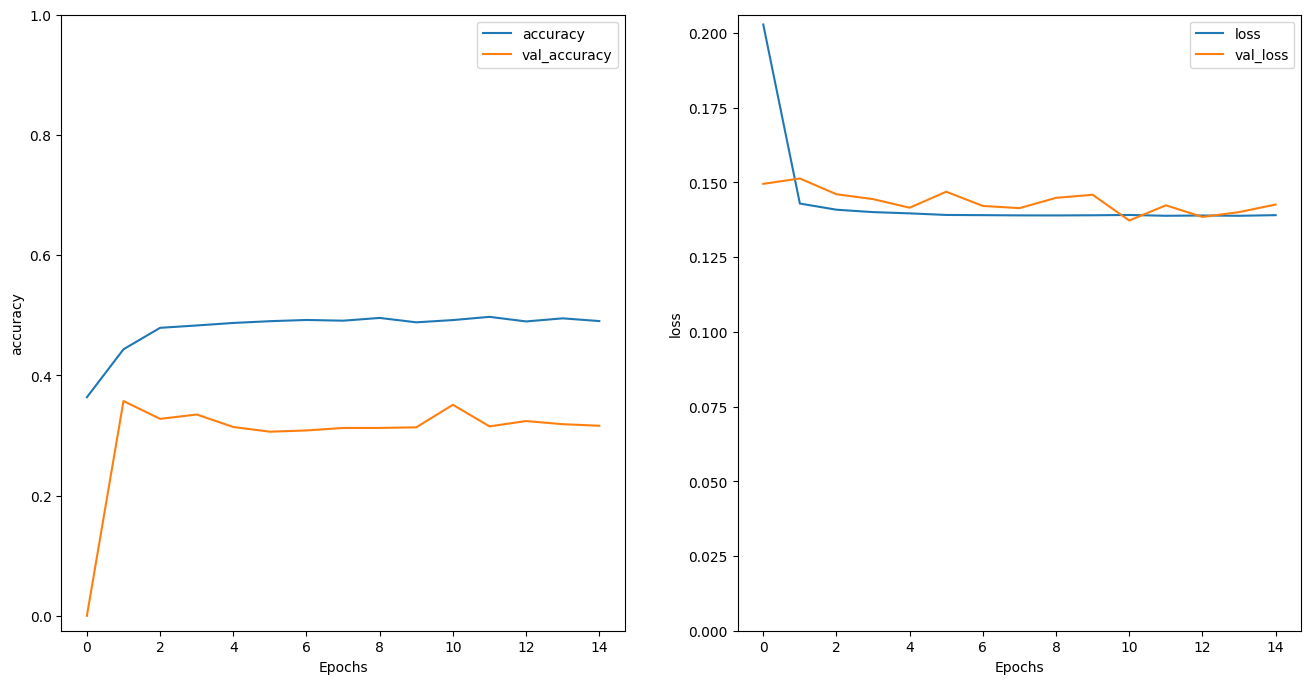

In [253]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [254]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[-2.2857416   0.27856848 -1.2231424  -3.6064527  -1.8771025  -2.6031597
 -3.2978287  -3.582226   -3.7783802  -2.7651303  -4.1119404  -2.8591523
 -5.3769155  -4.675372   -3.045183   -2.5604577  -4.211062   -3.3093452
 -3.6335995  -4.389809   -3.8251827  -5.439752   -3.6905093  -4.1822796
 -5.276904   -3.8208854  -5.707915   -3.8667262  -5.227036   -5.8146634
 -5.1493535  -3.9319835  -3.663801   -4.6595945  -5.5645876  -5.770327
 -4.753028   -4.429707   -4.779221   -6.3784766 ]


##### Experiment 4:

In [255]:
model = create_model(encoder_bigrams)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[ 4.7439667e-03  1.2241086e-02  7.8384886e-03  7.9077696e-03
  8.5314792e-03  2.4340740e-04 -2.7568860e-03 -2.9614968e-03
 -2.2304498e-03  4.3717972e-03 -8.9839427e-03 -6.7369378e-04
  2.6009039e-03 -1.1432599e-02  9.7173513e-05 -3.1474354e-03
  3.1539748e-04  1.3181512e-02 -4.6049464e-03 -6.0835425e-03
  2.3203206e-04 -1.8103212e-05 -8.9895232e-03  9.5824338e-04
 -9.8468075e-03  2.1982149e-03  1.7872183e-03 -3.2229323e-03
 -1.0248180e-02  4.1743289e-03 -5.9486418e-03 -3.8340988e-03
  6.8061105e-03  3.5543751e-03  4.6961379e-04 -3.3012708e-04
 -1.0822192e-03  1.3790767e-02 -5.2160872e-03 -8.6492123e-03]


In [256]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=["accuracy"])

In [257]:
run = wandb.init(project="multi_label_everything_v1", reinit=True)
wandb.config = {
    "learning_rate": 1e-3,
    "optimizer": "adam",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "bigram_count",
    "sample_id": "2"
}

history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
338/338 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.4192

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_003129-egvlbgq9\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_003129-egvlbgq9\files\model-best\assets


338/338 [==============================] - 544s 2s/step - loss: 0.2014 - accuracy: 0.4192 - val_loss: 0.1544 - val_accuracy: 0.0000e+00
Epoch 2/15
338/338 [==============================] - ETA: 0s - loss: 0.1437 - accuracy: 0.4225

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_003129-egvlbgq9\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_003129-egvlbgq9\files\model-best\assets


338/338 [==============================] - 537s 2s/step - loss: 0.1437 - accuracy: 0.4225 - val_loss: 0.1542 - val_accuracy: 0.0000e+00
Epoch 3/15
338/338 [==============================] - ETA: 0s - loss: 0.1433 - accuracy: 0.4300

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_003129-egvlbgq9\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_003129-egvlbgq9\files\model-best\assets


338/338 [==============================] - 532s 2s/step - loss: 0.1433 - accuracy: 0.4300 - val_loss: 0.1461 - val_accuracy: 0.3198
Epoch 4/15
338/338 [==============================] - 512s 2s/step - loss: 0.1415 - accuracy: 0.4712 - val_loss: 0.1474 - val_accuracy: 0.2953
Epoch 5/15
338/338 [==============================] - ETA: 0s - loss: 0.1405 - accuracy: 0.4751

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_003129-egvlbgq9\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_003129-egvlbgq9\files\model-best\assets


338/338 [==============================] - 533s 2s/step - loss: 0.1405 - accuracy: 0.4751 - val_loss: 0.1413 - val_accuracy: 0.3047
Epoch 6/15
338/338 [==============================] - 498s 1s/step - loss: 0.1400 - accuracy: 0.4789 - val_loss: 0.1442 - val_accuracy: 0.2812
Epoch 7/15
338/338 [==============================] - 498s 1s/step - loss: 0.1401 - accuracy: 0.4824 - val_loss: 0.1436 - val_accuracy: 0.2964
Epoch 8/15
338/338 [==============================] - 500s 1s/step - loss: 0.1398 - accuracy: 0.4793 - val_loss: 0.1452 - val_accuracy: 0.2786
Epoch 9/15
338/338 [==============================] - ETA: 0s - loss: 0.1397 - accuracy: 0.4768

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_003129-egvlbgq9\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_003129-egvlbgq9\files\model-best\assets


338/338 [==============================] - 524s 2s/step - loss: 0.1397 - accuracy: 0.4768 - val_loss: 0.1382 - val_accuracy: 0.2974
Epoch 10/15
338/338 [==============================] - 508s 2s/step - loss: 0.1394 - accuracy: 0.4838 - val_loss: 0.1429 - val_accuracy: 0.2828
Epoch 11/15
338/338 [==============================] - 521s 2s/step - loss: 0.1397 - accuracy: 0.4800 - val_loss: 0.1395 - val_accuracy: 0.2979
Epoch 12/15
338/338 [==============================] - 516s 2s/step - loss: 0.1397 - accuracy: 0.4813 - val_loss: 0.1414 - val_accuracy: 0.3120
Epoch 13/15
338/338 [==============================] - 515s 2s/step - loss: 0.1396 - accuracy: 0.4785 - val_loss: 0.1453 - val_accuracy: 0.2948
Epoch 14/15
338/338 [==============================] - 515s 2s/step - loss: 0.1397 - accuracy: 0.4823 - val_loss: 0.1383 - val_accuracy: 0.3135
Epoch 15/15
338/338 [==============================] - 515s 2s/step - loss: 0.1395 - accuracy: 0.4812 - val_loss: 0.1437 - val_accuracy: 0.2948


In [258]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

47/47 [==============================] - 15s 315ms/step - loss: 0.1451 - accuracy: 0.2933
Test Loss: 0.14508698880672455
Test Accuracy: 0.2933333218097687


(0.0, 0.20453665629029275)

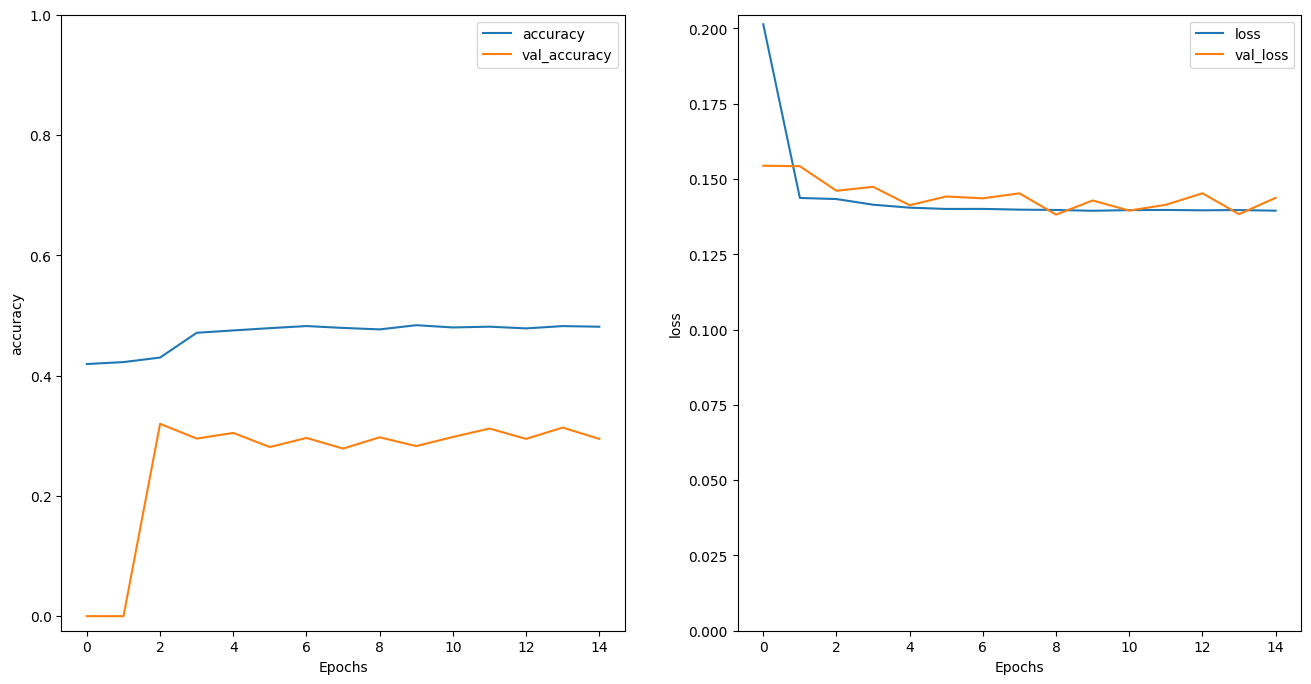

In [259]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [260]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[-0.83230174 -0.5881312  -0.72808385 -1.3766881  -0.47701406 -1.691016
 -1.6386398  -2.0899758  -2.22078    -1.992463   -2.2498891  -2.1709085
 -2.7985034  -2.4707227  -1.913232   -2.2461414  -2.4142122  -2.259098
 -2.0527062  -2.7270398  -1.841383   -2.7015228  -2.4662309  -2.6163442
 -2.7581553  -2.0925198  -2.7239645  -2.6892343  -3.3885093  -3.1600597
 -2.5799189  -2.6601634  -2.6896782  -2.745635   -2.7574818  -2.440563
 -2.4531722  -2.9910467  -2.855484   -3.187737  ]


##### Experiment 5:

In [261]:
model = create_model(encoder_tf_idf)
# predict on a sample formula using untrained model
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[-0.00707474  0.00284117 -0.00330093  0.00567339 -0.00058172  0.00245612
 -0.00207327  0.00090798 -0.00084923 -0.00125988  0.0058551   0.01314341
  0.00127046 -0.0014255   0.00964162  0.00651603  0.00428762 -0.00120967
 -0.00345879  0.00617907  0.00515835  0.00058763 -0.00381829 -0.00329466
  0.00562609  0.00418637 -0.00450963 -0.00588533  0.0004542  -0.00071292
 -0.00261393 -0.0053218  -0.00392864  0.00104584  0.01221902 -0.00182201
  0.00376329 -0.002002   -0.01178719  0.001547  ]


In [262]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=["accuracy"])

In [263]:
run = wandb.init(project="multi_label_everything_v1", reinit=True)
wandb.config = {
    "learning_rate": 1e-3,
    "optimizer": "adam",
    "epochs": 15,
    "batch_size": 64,
    "vectorizer": "tf_idf",
    "sample_id": "2"
}

history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30,callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/15
338/338 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.4108

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_024127-ydg3l7td\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_024127-ydg3l7td\files\model-best\assets


338/338 [==============================] - 198s 564ms/step - loss: 0.2064 - accuracy: 0.4108 - val_loss: 0.1464 - val_accuracy: 0.2698
Epoch 2/15
338/338 [==============================] - 168s 497ms/step - loss: 0.1417 - accuracy: 0.4613 - val_loss: 0.1464 - val_accuracy: 0.4828
Epoch 3/15
338/338 [==============================] - ETA: 0s - loss: 0.1393 - accuracy: 0.4958

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_024127-ydg3l7td\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_024127-ydg3l7td\files\model-best\assets


338/338 [==============================] - 190s 561ms/step - loss: 0.1393 - accuracy: 0.4958 - val_loss: 0.1416 - val_accuracy: 0.5339
Epoch 4/15
338/338 [==============================] - 170s 502ms/step - loss: 0.1379 - accuracy: 0.5045 - val_loss: 0.1432 - val_accuracy: 0.5349
Epoch 5/15
338/338 [==============================] - ETA: 0s - loss: 0.1371 - accuracy: 0.5112

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_024127-ydg3l7td\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_024127-ydg3l7td\files\model-best\assets


338/338 [==============================] - 191s 565ms/step - loss: 0.1371 - accuracy: 0.5112 - val_loss: 0.1399 - val_accuracy: 0.5771
Epoch 6/15
338/338 [==============================] - 168s 496ms/step - loss: 0.1367 - accuracy: 0.5156 - val_loss: 0.1410 - val_accuracy: 0.5714
Epoch 7/15
338/338 [==============================] - 168s 497ms/step - loss: 0.1360 - accuracy: 0.5192 - val_loss: 0.1420 - val_accuracy: 0.3130
Epoch 8/15
338/338 [==============================] - ETA: 0s - loss: 0.1357 - accuracy: 0.5198

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_024127-ydg3l7td\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_024127-ydg3l7td\files\model-best\assets


338/338 [==============================] - 191s 565ms/step - loss: 0.1357 - accuracy: 0.5198 - val_loss: 0.1385 - val_accuracy: 0.5344
Epoch 9/15
338/338 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.5250

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_024127-ydg3l7td\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_024127-ydg3l7td\files\model-best\assets


338/338 [==============================] - 188s 556ms/step - loss: 0.1354 - accuracy: 0.5250 - val_loss: 0.1361 - val_accuracy: 0.5703
Epoch 10/15
338/338 [==============================] - 168s 497ms/step - loss: 0.1352 - accuracy: 0.5225 - val_loss: 0.1409 - val_accuracy: 0.3422
Epoch 11/15
338/338 [==============================] - 167s 495ms/step - loss: 0.1350 - accuracy: 0.5232 - val_loss: 0.1411 - val_accuracy: 0.3464
Epoch 12/15
338/338 [==============================] - 168s 496ms/step - loss: 0.1348 - accuracy: 0.5240 - val_loss: 0.1393 - val_accuracy: 0.5484
Epoch 13/15
338/338 [==============================] - 169s 500ms/step - loss: 0.1346 - accuracy: 0.5251 - val_loss: 0.1370 - val_accuracy: 0.3552
Epoch 14/15
338/338 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.5215

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_024127-ydg3l7td\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_024127-ydg3l7td\files\model-best\assets


338/338 [==============================] - 189s 561ms/step - loss: 0.1345 - accuracy: 0.5215 - val_loss: 0.1360 - val_accuracy: 0.6047
Epoch 15/15
338/338 [==============================] - ETA: 0s - loss: 0.1343 - accuracy: 0.5246

INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_024127-ydg3l7td\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\prdie\OneDrive\Sources\sem_math_repo\classification\wandb\run-20230109_024127-ydg3l7td\files\model-best\assets


338/338 [==============================] - 190s 561ms/step - loss: 0.1343 - accuracy: 0.5246 - val_loss: 0.1352 - val_accuracy: 0.5807


In [264]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

47/47 [==============================] - 4s 93ms/step - loss: 0.1367 - accuracy: 0.5767
Test Loss: 0.13673630356788635
Test Accuracy: 0.5766666531562805


(0.0, 0.21004279404878617)

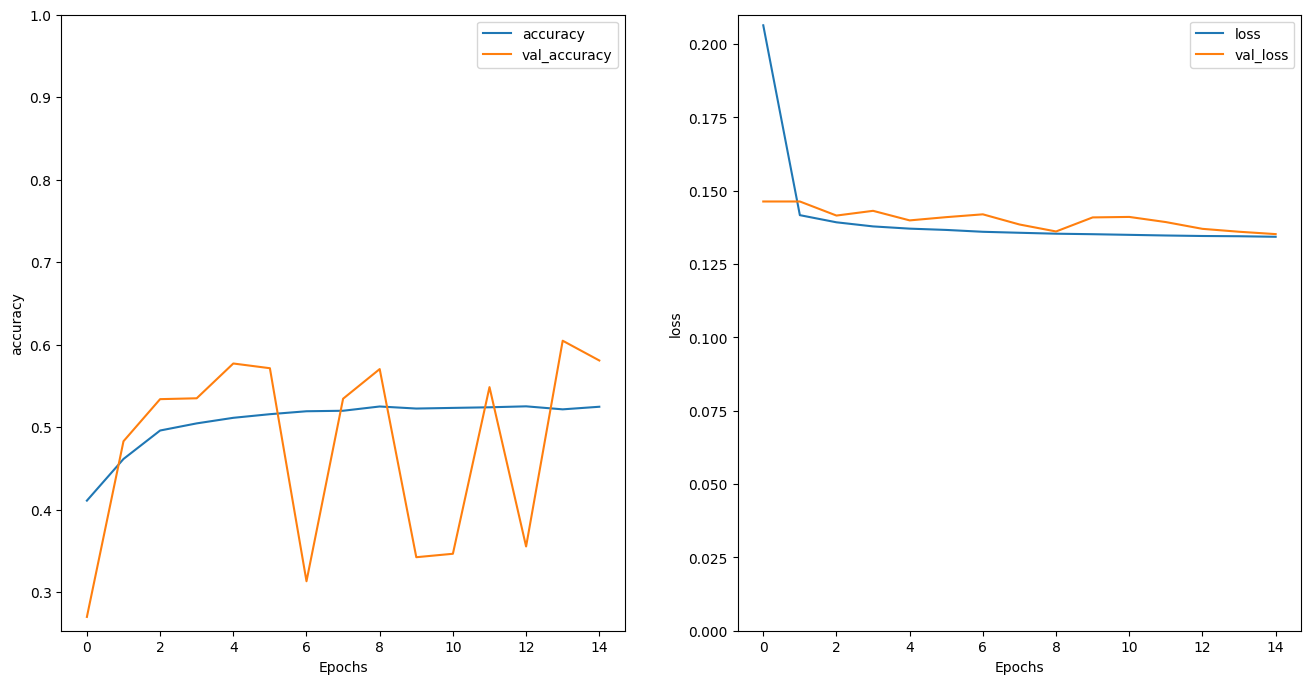

In [265]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [266]:
# predict on a sample text without padding
sample_text = ("g ( x ) = x ^ 3")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-2.1666944   0.03069463 -1.0758876  -3.1969934  -2.2509148  -2.4395015
 -3.5541692  -3.7295766  -3.7613022  -3.6314368  -4.2550774  -3.1800485
 -5.1689234  -4.5936933  -3.3040614  -3.7817369  -5.0883136  -3.4443617
 -3.6924982  -4.986865   -4.272576   -5.6622834  -3.9385839  -4.292074
 -5.323247   -4.3891463  -5.0754786  -3.980844   -6.0996666  -5.6994963
 -5.3923173  -4.243978   -4.085831   -5.2278075  -5.6907144  -6.0844593
 -5.0961313  -4.559098   -4.5952706  -6.203444  ]
